In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/review-raw.csv')[['author_id', 'app_id', 'voted_up', 'timestamp', 'review']].copy(deep=True)
df.head()

,author_id,app_id,voted_up,timestamp,review
0,76561197960432447,10,True,1738278781,A legendary tactical shooter that shaped the g...
1,76561198071230926,10,True,1736206418,"The best CS sure, but server browser is the il..."
2,76561198206216352,10,True,1738041574,Some of the best memories of my childhood were...
3,76561198110801124,10,True,1738015332,This game feels so much better than CS2. I kno...
4,76561199813732773,10,True,1737853720,its very fun to play you can make friends out ...


## Mapping user id and app id to indices

In [3]:
user_map = {u: i for i, u in enumerate(df['author_id'].unique())}
item_map = {i: j for j, i in enumerate(df['app_id'].unique())}

df['user_idx'] = np.array([user_map[u] for u in df['author_id']])
df['item_idx'] = np.array([item_map[i] for i in df['app_id']])
df['rating_int'] = df['voted_up'].astype(int)

## Splitting the data

In [4]:
df_train_eval, df_test = train_test_split(df[['user_idx', 'item_idx', 'rating_int']], test_size=0.1, random_state=42)
df_train, df_eval = train_test_split(df_train_eval, test_size=(0.1/0.9), random_state=42)

train_dataset = NCFDataset(df_train)
eval_dataset = NCFDataset(df_eval)
test_dataset = NCFDataset(df_test)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False)

unique_users = df["user_idx"].unique()
unique_items = df["item_idx"].unique()

In [5]:
print(df_train.shape)
print(df_eval.shape)
print(df_test.shape)

(1413153, 3)
(176645, 3)
(176645, 3)


## Train model

In [6]:
model = NCFRecommender(unique_users, unique_items)
model.fit(train_dataloader, eval_dataloader)

Epoch 1
-------------------------------
loss: 0.768205  [  256/1413153]
loss: 0.747881  [25856/1413153]
loss: 0.729712  [51456/1413153]
loss: 0.757479  [77056/1413153]
loss: 0.734396  [102656/1413153]
loss: 0.697407  [128256/1413153]
loss: 0.693570  [153856/1413153]
loss: 0.660424  [179456/1413153]
loss: 0.690643  [205056/1413153]
loss: 0.660340  [230656/1413153]
loss: 0.634344  [256256/1413153]
loss: 0.628638  [281856/1413153]
loss: 0.642558  [307456/1413153]
loss: 0.636001  [333056/1413153]
loss: 0.637851  [358656/1413153]
loss: 0.594645  [384256/1413153]
loss: 0.598754  [409856/1413153]
loss: 0.576477  [435456/1413153]
loss: 0.574407  [461056/1413153]
loss: 0.589863  [486656/1413153]
loss: 0.557897  [512256/1413153]
loss: 0.558176  [537856/1413153]
loss: 0.552395  [563456/1413153]
loss: 0.554169  [589056/1413153]
loss: 0.535275  [614656/1413153]
loss: 0.560924  [640256/1413153]
loss: 0.558120  [665856/1413153]
loss: 0.562245  [691456/1413153]
loss: 0.515280  [717056/1413153]
loss: 0

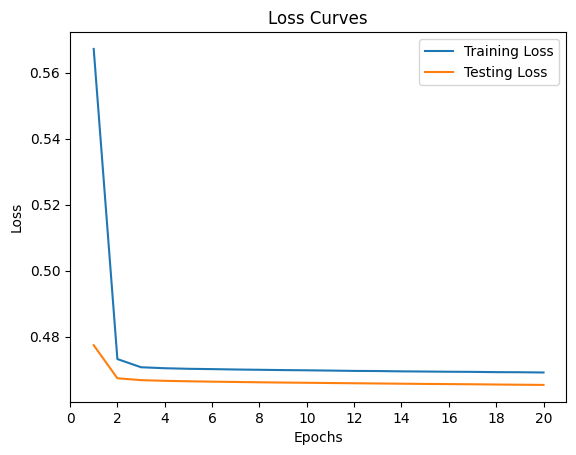

In [7]:
train_losses = model.train_losses
eval_losses = model.eval_losses
epochs = model.epochs

plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), eval_losses, label="Testing Loss")
plt.xticks(ticks=np.arange(0, epochs + 1, 2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [27]:
from evaluation import Evaluation

evaluator = Evaluation(predictions=predictions, ground_truth=ground_truth, k=10)
evaluator.evaluate()

{'Hit Ratio@10': 0.00016777622677977022,
 'NDCG@10': 5.344185010828497e-05,
 'Recall@10': 0.0001519573253976776}